# Analysis of Deaths by Vehicular Injury
## by Sarah Weinflash

In this report, I will be evaluating the relationship between road injuries and registered vehicles by country and by year. These two datasets were collected by the Organization of Economic Cooperation and Development, which uses the data to shape international policy and promote equity around the world. The road accidents we’ll be discussing include accidents related to any motor vehicle, so that includes buses, trams, scooters, etc. The registered vehicles are just passenger and commercial cars, so keep that in mind as you look at these visuals.

*Data Sources* 
- Country Codes: https://gist.github.com/radcliff/f09c0f88344a7fcef373#file-wikipedia-iso-country-codes-csv
- GDP Data: https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/ltst/endyear/ltst/indicator/NY-GDP-MKTP-CD
- Vehicular Injury Data: https://data.oecd.org/transport/road-accidents.htm#indicator-chart
- Vehicle Registration Data: https://data.oecd.org/transport/passenger-car-registrations.htm

In [1]:
import pandas as pd
import panel as pn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.figure import Figure
import param
import hvplot.pandas
import altair as alt
import requests
#import streamlit as st
import pywaffle
from pywaffle import Waffle
import plotly.express as px

I began by loading the necessary datasets. I merged the Vehicular data ("data") with the country code dataset ("country_code"), so that I could display the full country names in the visualizations below. To merge the GDP dataset ("gdp") with the full dataset, I "un-pivoted" the dataset and transformed the year values from strings into integers. I was then able to merge the datasets on both country and year. Because the GDP data was so skewed, I transformed the data by taking the square root of it. I named this variable "Transformed GDP". Finally, I separated the data into two groups: Countries with higher GDP and countries with lower GDP. 

In [7]:
# Load data
data = pd.read_csv('/Users/sarahweinflash/Desktop/Professional/Portfolio/Vehicular_Injuries_Data1.csv')
country_code = pd.read_csv('/Users/sarahweinflash/Desktop/Professional/Portfolio/Vehicular_Injuries_Data2.csv')
gdp = pd.read_csv('/Users/sarahweinflash/Desktop/Professional/Portfolio/Vehicular_Injuries_Data3.csv')

# Merge data with country code
data = data.merge(country_code, left_on='LOCATION', right_on='Alpha-3 code')
data = data[['YEAR', 'REGISTERED_VEHICLES','CAR_ACCIDENTS','English short name lower case']]
data = data.rename(columns={'YEAR':'Year', 'REGISTERED_VEHICLES':'Vehicles','CAR_ACCIDENTS':'Injuries','English short name lower case':'Country'})

# Melt GDP data
gdp = gdp.melt(id_vars = 'Country Name', value_vars = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'], var_name='Year', value_name='GDP')
gdp['Year'] = gdp['Year'].apply(int)

# Merge data & GDP data
data = data.merge(gdp, left_on=['Country','Year'], right_on=['Country Name', 'Year'])
data = data[['Country','Year','Injuries','GDP','Vehicles']]
data['Transformed_GDP'] = data['GDP'].apply(np.sqrt)

# Separate countries by GDP
grouped_data = data.groupby('Country').agg('sum')
grouped_data.sort_values(by='Transformed_GDP',ascending=False)
Rank = []
for i in data['Country']:
    if i in ['United States','Japan','United Kingdom', 'Germany', 'Italy','Norway','Belgium','Poland','Sweden','Netherlands','Switzerland','Australia','Turkey','Spain','Canada','Austria']:
        Rank.append('Higher GDP')
    else:
        Rank.append('Lower GDP')
data['Rank'] = Rank
rank0 = data[data['Rank'] == 'Higher GDP']
rank1 = data[data['Rank'] == 'Lower GDP']

The scatterplot below shows the countries on the x axis and number of injuries in road accidents on the y axis. The purple line shows the mean number of injuries per country. Across the years, you can see that there’s some random fluctuation, but the mean drops significantly between 2019 and 2020. I believe this is related to the shelter-in-place orders in 2020, as fewer people traveling means fewer road injuries. This drop was most significant among countries with higher number of injuries, so I wanted to examine that relationship further.

In [3]:
# Scatterplot - Slider 

slider = alt.binding_range(min=2011, max=2021, step=1, name='Year')
selection = alt.selection_point(fields=['Year'], bind=slider)
opacity = alt.condition(selection, alt.value(1.0), alt.value(0))

order1 = data.groupby('Country').agg('sum')
order1 = order1.sort_values('Injuries', ascending=False)
order1 = list(order1.index)

chart1 = alt.Chart(data, title = 'Injuries in Road Accidents by Country').mark_point(filled=True, size=50, color='salmon').encode(
    x = alt.X('Country:N', sort = order1),
    y = 'Injuries:Q',
    opacity = opacity
).add_params(selection)

line1 = alt.Chart().mark_rule(color='#6b6ecf').encode(
    y='mean(Injuries):Q',
    size=alt.SizeValue(3)
).transform_filter(
    selection
)

alt.layer(chart1, line1, data=data) 

/var/folders/m_/bn7_5xgd5k78dxpv8nsvb1r00000gn/T/ipykernel_57017/2710675299.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order1 = data.groupby('Country').agg('sum')


alt.LayerChart(...)

The scatterplot below has the year on the x axis and the number of injuries on the y axis. I highlighted the countries with the highest number of injuries - Austria, Belgium, Japan, New Zealand, and the United States - using colored points; I also generated a separate regression line for them, which is labeled “Top 5”. You can compare that to the regression line for injuries by year in all countries, labeled “All Countries”. Although the general trend for both that the number of injuries decreases by year, you can see there is a much stronger trend among those top 5 countries than all the countries. I also noticed that those top 5 countries had significantly more accidents than all the rest of the countries. I wanted to examine the distribution further.

In [4]:
# Scatterplot - Injuries per Year
    # separated by Top 5 vs Total
    # incl regression lines

data_grouped1 = data.groupby(['Country','Year'], as_index=False).agg('sum')
data_grouped1.sort_values(by='Injuries')
data_grouped1 = data_grouped1[data_grouped1['Country'].isin(['United States','New Zealand','Belgium','Austria','Japan'])]

points1 = alt.Chart(data_grouped1, title = 'Vehicular Injuries per Year').mark_point(filled=True, opacity=1).encode(
    x = 'Year:O',
    y = 'Injuries:Q',
    color = alt.Color('Country:N'),
    tooltip = ['Country:N']
)

line1 = points1.transform_regression('Year','Injuries').mark_line(opacity=1, color='#6b6ecf').encode(color=alt.Color(legend=None))

points2 = alt.Chart(data, title = 'Vehicular Injuries per Year').mark_point(filled=True, opacity=0.3, color='black').encode(
    x = 'Year:O',
    y = 'Injuries:Q'
)

line2 = points2.transform_regression('Year','Injuries').mark_line(opacity=1, color='black').encode(color=alt.Color(legend=None)) 

annotation1 = alt.Chart(data).mark_text(
    align = 'left',
    fontSize = 15,
    color = '#6b6ecf'
).encode(
    x = alt.value(225),
    y = alt.value(150),
    text = alt.value(['Top 5'])
)

annotation2 = alt.Chart(data).mark_text(
    align = 'left',
    fontSize = 15,
    color = 'black'
).encode(
    x = alt.value(225),
    y = alt.value(225),
    text = alt.value(['All Countries'])
)    
points2 + points1 +  line1 + line2 + annotation1 + annotation2

/var/folders/m_/bn7_5xgd5k78dxpv8nsvb1r00000gn/T/ipykernel_57017/4006470148.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_grouped1 = data.groupby(['Country','Year'], as_index=False).agg('sum')


alt.LayerChart(...)

I created what’s called a waffle chart to further examine the distribution of number of accidents by country. Each block represents 10,000 injuries. The pink blocks represent the top 5 countries by number of injuries; the yellow represents the next 10 countries, and the green represents the remaining 26 countries. You can see that although the top 5 countries represent only about 10% of countries in the dataset, represent about 30% of injuries. 

/var/folders/m_/bn7_5xgd5k78dxpv8nsvb1r00000gn/T/ipykernel_57017/2264218409.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_grouped = data.groupby('Country').agg('sum')


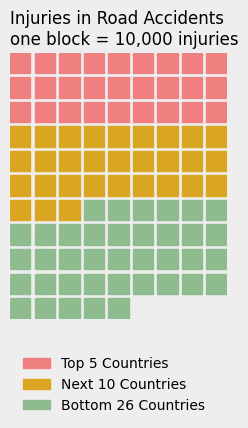

In [5]:
# Group & Filter Data 
    
    # sum the injuries by country
data_grouped = data.groupby('Country').agg('sum')
data_grouped = data_grouped.reset_index()
data_grouped = data_grouped[['Country','Injuries']]
#data_grouped.sort_values('Injuries', ascending=False)

    # divide into categories
filtered_data = {}
filtered_data['Top 5 Countries'] = data_grouped[data_grouped['Injuries']>50000].sum()[1]
filtered_data['Next 10 Countries'] = data_grouped[(data_grouped['Injuries']>35000) & (data_grouped['Injuries']<50000)].sum()[1]
filtered_data['Bottom 26 Countries'] = data_grouped[data_grouped['Injuries']<35000].sum()[1]

    # divide to generate appropriate number of blocks
for i,j in filtered_data.items():
    filtered_data[i] = int(j/10000)

fig = plt.figure(
    FigureClass=Waffle,
    rows=11,
    values=filtered_data,
    colors=['lightcoral','goldenrod','darkseagreen'],
    title={'label': 'Injuries in Road Accidents \none block = 10,000 injuries', 'loc': 'left'},
    labels=[f"{k}" for k, v in filtered_data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': 1, 'framealpha': 0},
    starting_location='NW',
    vertical=True
)
fig.set_facecolor('#EEEEEE')
plt.show()

I was interested in the relationship between GDP in these countries and the number of injuries. I separated the dataset into two groups: higher GDP and lower GDP. The countries with higher GDP are colored pink, and those with lower GDP are colored purple. I generated the scatterplot below, which has the number of registered vehicles on the X axis and injuries on the Y axis. The lines on the plot are regression lines, and you can see that both groups have downward slopes, meaning that there are fewer injuries for every additional registered vehicle. That’s surprising on its own, but even more surprising to me was that the countries with lower GDPs had more registered vehicles. 

I created box plots of the number of vehicles (below) and number of injuries (to the right). You can see that actually, those countries with high numbers of registered vehicles are outliers, and that all countries have a median of around 1200 registered vehicles. In terms of injuries, there is a slight difference in spread between countries with low and high GDPs, with countries with high GDPs having more injuries than those with lower GDPs, and a wider spread. All of the outlying points in the Low GDP group are from New Zealand. 

I found the tooltip (which shows the name of the country when you hover over the data point with your mouse) to be useful on a small scale, but ultimately difficult to get a good sense of the data all together. Use your mouse to select a block of points on the scatterplot; you can see the results in the bar chart on the right. You can get a much better sense of which countries the data are coming from and what the distribution is. For example, all of these top points are from New Zealand and the US. All of these leverage points are from Lithuania. Play around with it and see what elese you can find! 

In [8]:
# Create plots for GDP/Vehicle/Injury Comparison

brush = alt.selection_interval()

# Scatterplots
points1 = alt.Chart(rank0, title = 'Vehicular Injuries by Number of Vehicles per Country').mark_point(filled=True, color='salmon',opacity=0.5).encode(
    alt.X('Vehicles:Q', scale=alt.Scale(domain=[0, 3500])),
    alt.Y('Injuries:Q', scale=alt.Scale(domain=[0, 10000])),
    tooltip = ['Country']
)
points2 = alt.Chart(rank1, title = 'Vehicular Injuries by Number of Vehicles per Country').mark_point(filled=True, color='#6b6ecf',opacity=0.5).encode(
    alt.X('Vehicles:Q', scale=alt.Scale(domain=[0, 3500])),
    alt.Y('Injuries:Q', scale=alt.Scale(domain=[0, 10000])),
    tooltip = ['Country']
).add_params(brush)

# Boxplots
bp0 = alt.Chart(rank0).mark_boxplot(color='salmon').encode(y = alt.Y('Injuries:Q', title=None, scale=alt.Scale(domain=[0,10000])))
bp1 = alt.Chart(rank1).mark_boxplot(color='#6b6ecf').encode(y = alt.Y('Injuries:Q', title=None, scale=alt.Scale(domain=[0,10000])))
bp00 = alt.Chart(rank0).mark_boxplot(color='salmon').encode(x = alt.X('Vehicles:Q', title=None, scale = alt.Scale(domain=[0,3500])))
bp11 = alt.Chart(rank1).mark_boxplot(color='#6b6ecf').encode(x = alt.X('Vehicles:Q', title=None, scale = alt.Scale(domain=[0,3500])))

# Regression Lines
line1 = points1.transform_regression('Vehicles','Injuries').mark_line(opacity=1, color='salmon') 
line2 = points2.transform_regression('Vehicles','Injuries').mark_line(opacity=1, color='#6b6ecf') 

# Bar Chart
bars = alt.Chart(data).mark_bar().encode(
    x = alt.X('count()', scale=alt.Scale(domain=[0,11])),
    y = alt.Y('Country:N'),
    color=alt.Color('Rank:N', scale=alt.Scale(domain=['Lower GDP', 'Higher GDP'], range=['#6b6ecf','salmon']))
).transform_filter(
    brush
)

# Print Chart
alt.layer(line2, points2, data=rank1) + alt.layer(points1, line1, data=rank0) & bp11 & bp00 | bp1 | bp0 | bars

alt.HConcatChart(...)

Vehicular transportation transforms lives and countries; it enables people access to food, healthcare, and education. To promote global development, it is of the utmost importance to ensure safety during travel. By examining this data as a time series, we can see the trends within individual countries and overall. By looking at the information as a function of national economies, we can understand how wealth impacts road accidents and vehicle registrations. I hope that this analysis can move us towards global road safety and thus universal access to necessary resources. 